<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Импорт-и-изучение-файлов" data-toc-modified-id="1-Импорт-и-изучение-файлов-1">1 Импорт и изучение файлов</a></span><ul class="toc-item"><li><span><a href="#1.1-Вывод" data-toc-modified-id="1.1-Вывод-1.1">1.1 Вывод</a></span></li></ul></li><li><span><a href="#2-Анализ-данных" data-toc-modified-id="2-Анализ-данных-2">2 Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Парсер-1" data-toc-modified-id="Парсер-1-2.1">Парсер 1</a></span></li><li><span><a href="#Парсер-2" data-toc-modified-id="Парсер-2-2.2">Парсер 2</a></span></li><li><span><a href="#2.1-Вывод" data-toc-modified-id="2.1-Вывод-2.3">2.1 Вывод</a></span></li></ul></li><li><span><a href="#3-Общие-рекомендации" data-toc-modified-id="3-Общие-рекомендации-3">3 Общие рекомендации</a></span></li></ul></div>

Проект представляет собой анализ рынка заведений общественного питания в Москве. Цель - определить:
- наиболее распространенный формат заведений;
- оптимальное количество посадочных мест;
- подходящую локацию.  

На основе выявленных закономерностей рынка дать рекомендации.

### 1 Импорт и изучение файлов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import requests
import re
from bs4 import BeautifulSoup
pd.set_option('display.max_colwidth', -1)

In [2]:
df1 = pd.read_csv(r'C:\Users\Гена\Desktop\DA\Учебные проекты\To_eat/rest_data.csv')
df1.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Создадим копию исходной таблицы, посмотрим общую информацию по данным. Проверим, являются ли id объектов уникальными, а также посмотрим состав столбца object_type

In [3]:
df = df1.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
df['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [6]:
df['id'].nunique()

15366

Id объектов уникальны. Изменим тип данных столбца object_type на категориальный и заменим здесь названия "предприятие быстрого обслуживания" и "магазин (отдел кулинарии)" на более короткие - "фастуд" и "магазин", соответственно.

In [7]:
df.loc[df['object_type'] =='предприятие быстрого обслуживания', 'object_type'] = 'фастфуд'
df.loc[df['object_type'] =='магазин (отдел кулинарии)', 'object_type'] = 'магазин'

In [8]:
df['object_type'] = df.object_type.astype('category')

In [9]:
df.dtypes

id             int64   
object_name    object  
chain          object  
object_type    category
address        object  
number         int64   
dtype: object

In [10]:
df.sample(5, random_state=5)

,id,object_name,chain,object_type,address,number
7628,84358,Шоколадница,да,кафе,"город Москва, проспект Андропова, дом 8",25
13524,214230,Выпечка,нет,магазин,"город Москва, 1-я Владимирская улица, дом 43",0
33,69243,Суши Wok,да,кафе,"город Москва, проспект Андропова, дом 30",4
1101,156704,KFC,да,ресторан,"город Москва, Страстной бульвар, дом 4, строение 1",160
1397,149825,Домино'с Пицца,да,кафе,"город Москва, Ярославское шоссе, дом 55, корпус 1",10


Проверим наличие дубликатов

In [11]:
display(df.loc[df.duplicated(keep=False)])

,id,object_name,chain,object_type,address,number


In [12]:
df['object_name'] = df['object_name'].str.lower()

In [13]:
df['object_name'] = df['object_name'].str.replace('кафе', '')
df['object_name'] = df['object_name'].str.replace('ресторан', '')

#### 1.1 Вывод

Исходные данные не содержат пропущенных значений. Предобработка данных включала:
- проверку данных на наличие дубликатов;
- замена в столбце object_type значений "магазин (отдел кулинарии)" и "предприятие быстрого питания" на "магазин" и "фастфуд" соответственно для краткого отображения данных;
- изменение типа данных столбца object_type на  категориальный.  

### 2 Анализ данных

2.1 Посмотрим на соотношение видов объектов общественного питания по количеству

In [14]:
df.sample(5)

,id,object_name,chain,object_type,address,number
7364,28122,московский ювелирный завод,нет,столовая,"город Москва, Нагатинская улица, дом 5",150
1680,152994,дюплекс,нет,кафе,"город Москва, Сокольническая площадь, дом 9",40
3637,21782,«шоколадница»,да,кафе,"город Москва, Климентовский переулок, дом 10, строение 1",50
1838,20515,лобби-бар «аквамарин»,нет,бар,"город Москва, Озерковская набережная, дом 26",120
9495,164571,нихони,нет,кафе,"город Москва, Сигнальный проезд, дом 17",30


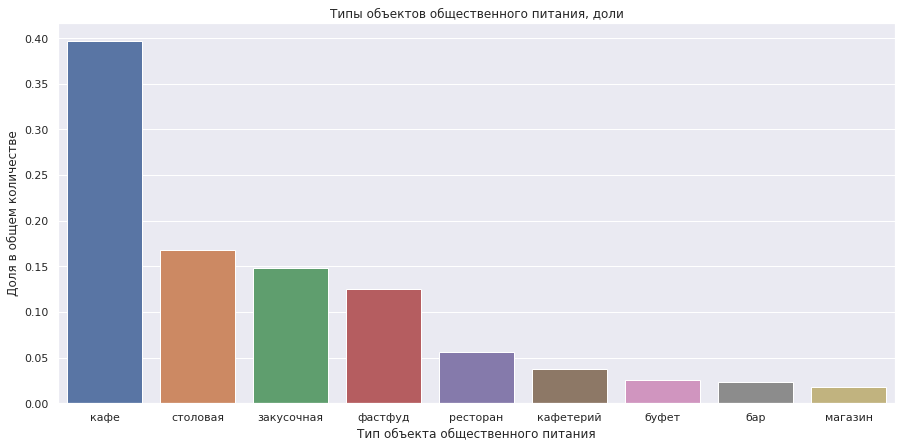

In [15]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.barplot(x = df['object_type'].unique(),
            y=df['object_type'].value_counts(normalize=True), 
            data=df)
ax.set(xlabel='Тип объекта общественного питания', 
       ylabel='Доля в общем количестве', 
       title='Типы объектов общественного питания, доли')
plt.show()

Около 40% рынка занимают кафе, при этом их доля в 2 раза выше следующего по количеству типа "столовая", у которого около 17%. Менее всего на рынке представлены кулинарные отделы в магазинах с долей около 2%.

2. Соотношение сетевых и несетевых заведений по количеству

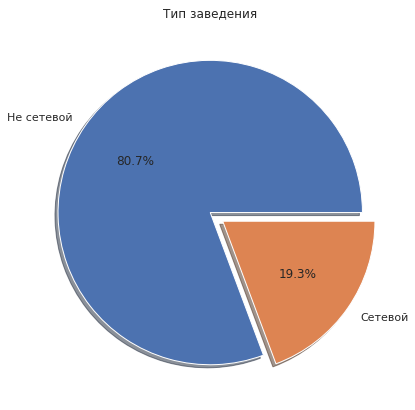

In [16]:
ax = df['chain'].value_counts(normalize=True)\
    .plot(kind='pie', title="Тип заведения", 
    autopct='%1.1f%%', explode=(0, 0.1), 
    shadow=True, startangle=0, labels=['Не сетевой', 'Сетевой'], figsize=(7,7))
ax.set_ylabel('')
plt.show()

Почти 81% заведений не являются сетевыми.

3. Выясним, для какого вида объекта общественного питания характерно сетевое распространение. Для этого сгруппируем данные по object_type, посчитав количество сетевых и несетевых заведений. Также определим доли сетевых и несетевых заведений для каждого типа объектов.

In [17]:
type_chain = df.pivot_table(index = 'object_type',
               columns = 'chain',
               values = 'id',
               aggfunc = 'count').reset_index()
type_chain.columns = ['тип', 'сетевой', 'несетевой']
type_chain['%сетевых'] = type_chain['сетевой'] / type_chain.sum(axis=1, numeric_only = True)*100
type_chain['%несетевых'] = type_chain['несетевой'] / (type_chain['сетевой']+type_chain['несетевой'])*100

In [18]:
type_chain = type_chain.sort_values('%сетевых', ascending=False)
type_chain

,тип,сетевой,несетевой,%сетевых,%несетевых
8,фастфуд,791,1132,41.133645,58.866355
5,магазин,78,195,28.571429,71.428571
6,ресторан,544,1741,23.807440,76.192560
3,кафе,1396,4703,22.888998,77.111002
2,закусочная,56,304,15.555556,84.444444
4,кафетерий,52,346,13.065327,86.934673
0,бар,37,819,4.322430,95.677570
1,буфет,11,574,1.880342,98.119658
7,столовая,3,2584,0.115964,99.884036


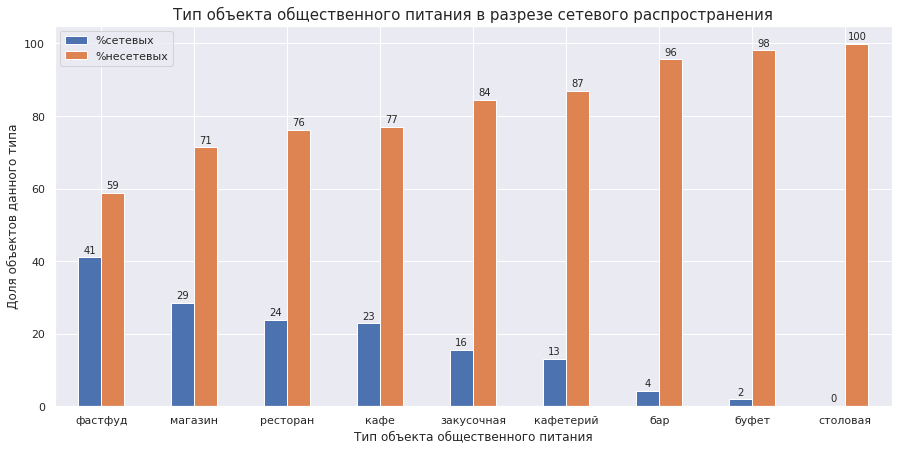

In [91]:
ax = type_chain[['%сетевых', '%несетевых']].plot(kind = 'bar', figsize = (15,7))
ax.set_xlabel('Тип объекта общественного питания', size = 12)
ax.set_ylabel('Доля объектов данного типа', size = 12)
ax.set_xticklabels(type_chain['тип'], rotation=0)
plt.title('Тип объекта общественного питания в разрезе сетевого распространения', size = 15)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center',
    size=10, xytext=(0, 7),
    textcoords='offset points')
plt.show()

41% предприятий быстрого питания принадлежит сетям, далее следуют кулинарные отделы магазинов, рестораны и кафе. Сюрпризом стала сеть столовых.

4. Обратимся к сетевым заведениям: характерно ли для них много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест.

Посмотрим на распределение сетевых заведений в зависимости от вместительности

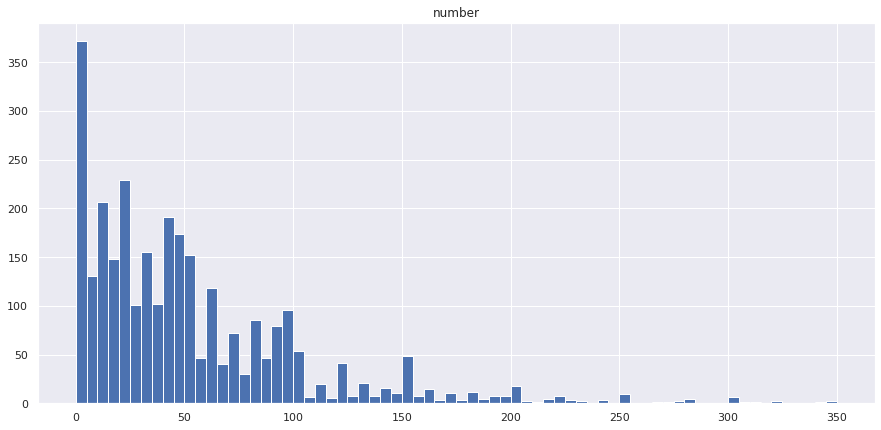

In [20]:
df.query('chain == "да"').hist(column = 'number', bins=70, range = (0,350))
plt.show()

БОльшая часть заведений вмещает до 100 человек. Проверим это утверждение и построим точечную диаграмму числа посадочных мест.

In [21]:
chain = df[df['chain'] == 'да']

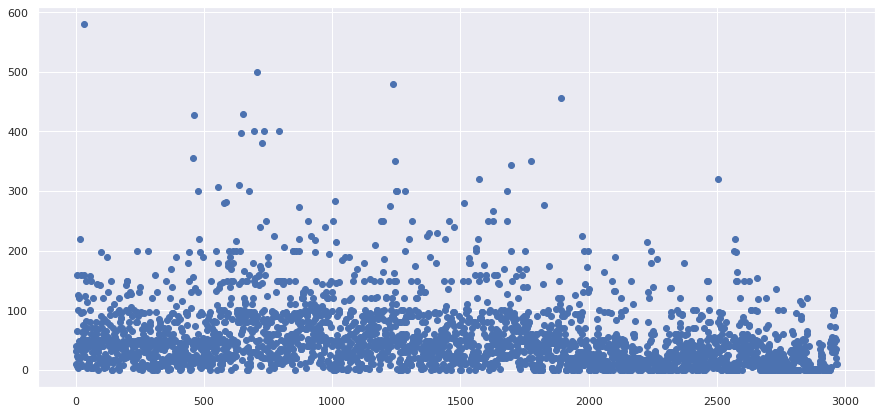

In [22]:
x_values = pd.Series(range(0,len(chain)))
plt.figure(figsize=(15,7))
plt.scatter(x_values, chain['number'])
plt.show()

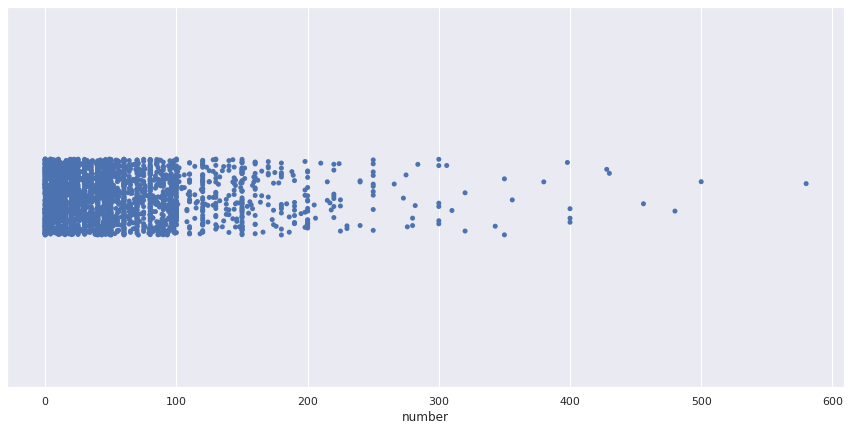

In [23]:
sns.stripplot(x = chain['number'])
plt.show()

Здесь также вместимость до 100 человек преобладает, но точная доля не ясна. Определим 10,5 и 1 процентили.

In [24]:
np.percentile(chain['number'], [90, 95, 99])

array([120.  , 158.65, 275.33])

90% заведений вмещают не более 120 человек, только 1% вмещает более 275 человек.  
Сделаем разбивку объектов на группы в зависимости от количества посадочных мест. Построим графики по тем типам заведений, которые в количественном отношении будут преобладать.

In [25]:
chain['number_group'] = pd.cut(chain.number, [0,30,60,90,120,150,180,210, 1800], right=False)

In [94]:
grouped = chain.pivot_table(
    index = 'number_group',
    columns = 'object_type',
    values = 'id',
    aggfunc = 'count').fillna(0)
grouped

object_type,бар,буфет,закусочная,кафе,кафетерий,магазин,ресторан,столовая,фастфуд
number_group,,,,,,,,,
"[0, 30)",11.0,9.0,45.0,539.0,45.0,70.0,63.0,0.0,406.0
"[30, 60)",13.0,1.0,9.0,472.0,5.0,8.0,108.0,1.0,203.0
"[60, 90)",4.0,1.0,1.0,197.0,2.0,0.0,102.0,0.0,85.0
"[90, 120)",5.0,0.0,1.0,98.0,0.0,0.0,104.0,0.0,52.0
"[120, 150)",2.0,0.0,0.0,34.0,0.0,0.0,48.0,1.0,20.0
"[150, 180)",2.0,0.0,0.0,28.0,0.0,0.0,47.0,1.0,10.0
"[180, 210)",0.0,0.0,0.0,11.0,0.0,0.0,35.0,0.0,5.0
"[210, 1800)",0.0,0.0,0.0,17.0,0.0,0.0,37.0,0.0,10.0


Кафе, фастфуд и рестораны наиболее представительны, построим графики по этим типам заведений.

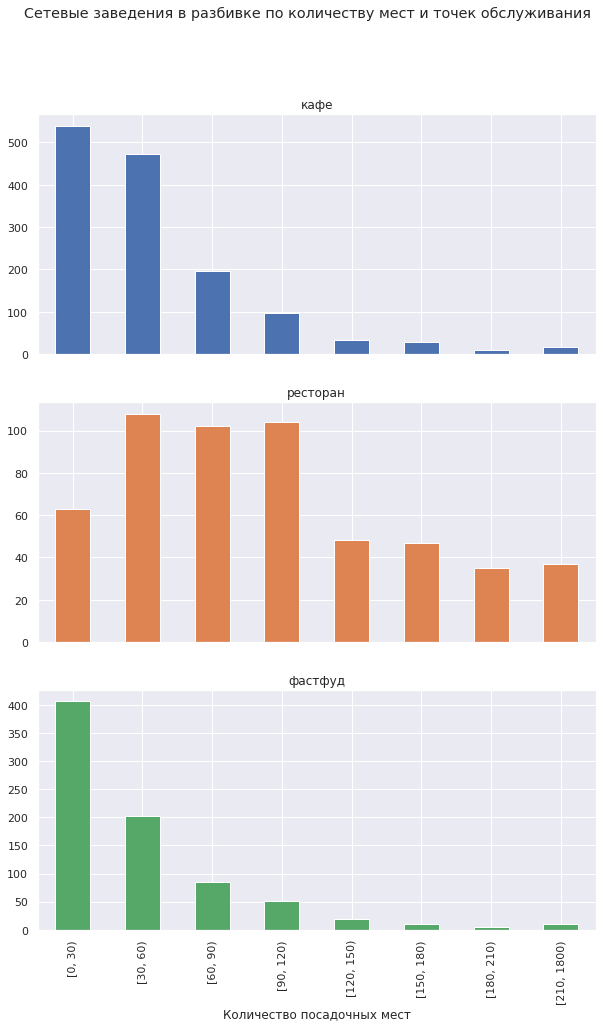

In [100]:
axes = grouped[['кафе', 'ресторан', 'фастфуд']].plot.bar(
    subplots=True, legend = False, figsize = (10,15), sharex=True, 
    title = 'Сетевые заведения в разбивке по количеству мест и точек обслуживания')

ax.set_xticklabels(grouped.index, rotation=0)
axes[2].set_xlabel('Количество посадочных мест')
plt.show()

Сетевые объекты общественного питания в основном предпочитают иметь большое количество точек обслуживания с меньшим количеством посадочных мест. 
В кафе две трети объектов  - около 1000 - вмещают до 60 человек. Возможно, чем ближе расположение объекта к центральным районам, тем меньше человек он вмещает из-за высокой стоимости аренды помещения.  
В сетевом фастфуде порядка 400 объектов вмещают одновременно до 30 человек. Это объяснется необходимостью обеспечить масштаб производства: чтобы поддерживать низкий уровень цен, нужно обслужить как можно больше человек с наименьшими расходами (небольшая площадь помещения, неудобные твердые стулья - условия для быстрой смены посетителей). Поэтому следующая группа в этой категории - от 30 до 60 человек - включает заметно меньше объектов - около 200. И далее снижение ускоряется.  
В категории "ресторан" примерно равное распределение в группах 30-60, 60-90 и 90-120 человек - около 100 ресторанов в каждой группе. Здесь, в отличие от фастфуда, наоборот плотность размещения посетителей меньше,  мебель комфортная, средний чек ощутимее выше. Возможно, чем больше посадочных мест, тем меньше средний чек в ресторане и наоборот. Но здесь, конечно, определяющий фактор - уровень кухни.

Сгруппируем заведения по сетям, рассмотрим "среднее число посадочных мест" и "число заведений" для сетей. Разобьем сети на 4 группы и посмотрим, в какой группе больше сетей. Т.к. от типа заведения зависит количество объектов в сети, ограничимся типами "кафе", "фастфуда" и "ресторан", как самыми многочисленными. Сети, состоящие из 1 заведения отбросим.

In [28]:
grouped = chain.pivot_table(
    index = 'object_name',
    columns = 'object_type',
    values= ['number', 'id'],
    aggfunc = {"number": np.mean, "id": 'count'})#.reset_index()
grouped.head()

id                                                   \
object_type              бар буфет закусочная кафе кафетерий магазин ресторан   
object_name                                                                     
 kfc                     NaN NaN   NaN        NaN  NaN       NaN     NaN        
 prime прайм стар        NaN NaN   NaN        NaN  NaN       NaN      1.0       
 prime прайм стар прайм- NaN NaN   NaN         1.0 NaN       NaN     NaN        
 starbucks               NaN NaN   NaN        NaN  NaN       NaN     NaN        
 «costa coffee»          NaN NaN   NaN         2.0 NaN       NaN     NaN        

                                          number                         \
object_type              столовая фастфуд    бар буфет закусочная  кафе   
object_name                                                               
 kfc                     NaN       2.0    NaN    NaN   NaN        NaN     
 prime прайм стар        NaN      NaN     NaN    NaN   NaN        NaN     
 prime прайм стар прайм- NaN      NaN     NaN    NaN   NaN         12.0   
 starbucks               NaN       1.0    NaN    NaN   NaN        NaN     
 «costa coffee»          NaN      NaN     NaN    NaN   NaN         20.5   

                                                                      
object_type              кафетерий магазин ресторан столовая фастфуд  
object_name                                                           
 kfc                     NaN       NaN     NaN      NaN       25.0    
 prime прайм стар        NaN       NaN      23.0    NaN      NaN      
 prime прайм стар прайм- NaN       NaN     NaN      NaN      NaN      
 starbucks               NaN       NaN     NaN      NaN       19.0    
 «costa coffee»          NaN       NaN     NaN      NaN      NaN

In [29]:
grouped.columns = ['_'.join(col).strip()for col in grouped.columns.values]

In [30]:
grouped.columns = ['qty_бар', 'qty_буфет', 'qty_закусочная', 'qty_кафе', 'qty_кафетерий',
       'qty_магазин', 'qty_ресторан', 'qty_столовая', 'qty_фастфуд', 'mean_num_бар',
       'mean_num_буфет', 'mean_num_закусочная', 'mean_num_кафе', 'mean_num_кафетерий',
       'mean_num_магазин', 'mean_num_ресторан', 'mean_num_столовая',
       'mean_num_фастфуд']

In [31]:
grouped_chain = grouped[
    ['qty_кафе','qty_ресторан', 'qty_фастфуд','mean_num_кафе', 'mean_num_ресторан','mean_num_фастфуд']
].query('qty_кафе > 1 or qty_ресторан > 1 or qty_фастфуд > 1')

In [32]:
grouped_chain[['qty_кафе','qty_ресторан','qty_фастфуд']].max()

qty_кафе        150.0
qty_ресторан    37.0 
qty_фастфуд     103.0
dtype: float64

In [33]:
grouped_chain['кафе'] = pd.cut(
    grouped_chain['qty_кафе'], [2,11,31,51,81,110], right=False).astype(str)

In [34]:
grouped_chain['ресторан'] = pd.cut(
    grouped_chain['qty_ресторан'], [2,11,21,31,40], right=False).astype(str)

In [35]:
grouped_chain['фастфуд'] = pd.cut(
    grouped_chain['qty_фастфуд'], [2,11,31,51,81,150], right=False).astype(str)

In [36]:
grouped_chain.sample(10)

,qty_кафе,qty_ресторан,qty_фастфуд,mean_num_кафе,mean_num_ресторан,mean_num_фастфуд,кафе,ресторан,фастфуд
object_name,,,,,,,,,
«хинкальная»,3.0,1.0,NaN,51.666667,60.000000,NaN,"[2.0, 11.0)",nan,nan
tgi fridays,NaN,2.0,NaN,NaN,39.000000,NaN,nan,"[2.0, 11.0)",nan
correas,2.0,1.0,NaN,50.000000,32.000000,NaN,"[2.0, 11.0)",nan,nan
космик,3.0,NaN,NaN,162.000000,NaN,NaN,"[2.0, 11.0)",nan,nan
пицца фабрика,5.0,NaN,NaN,29.800000,NaN,NaN,"[2.0, 11.0)",nan,nan
чебуречная ссср,6.0,NaN,NaN,45.666667,NaN,NaN,"[2.0, 11.0)",nan,nan
«пицца фабрика»,2.0,NaN,NaN,22.000000,NaN,NaN,"[2.0, 11.0)",nan,nan
тануки,3.0,29.0,NaN,75.333333,117.862069,NaN,"[2.0, 11.0)","[21.0, 31.0)",nan
«kfc»,1.0,2.0,10.0,54.000000,63.000000,55.4,nan,"[2.0, 11.0)","[2.0, 11.0)"


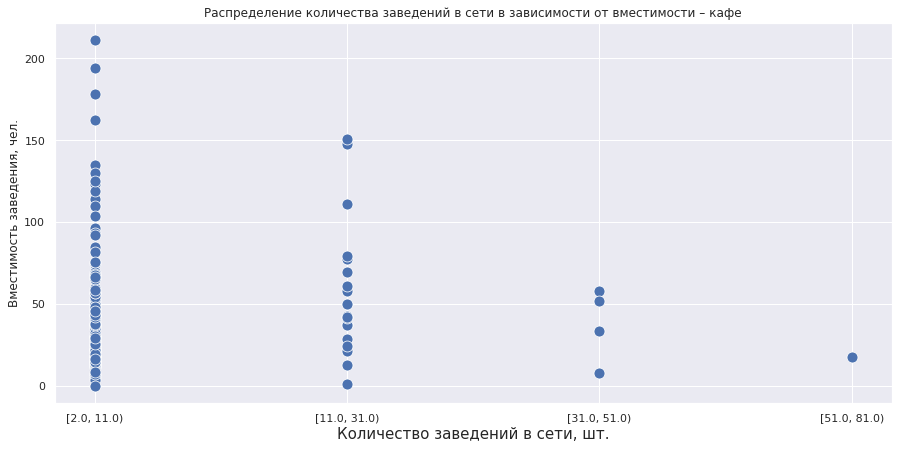

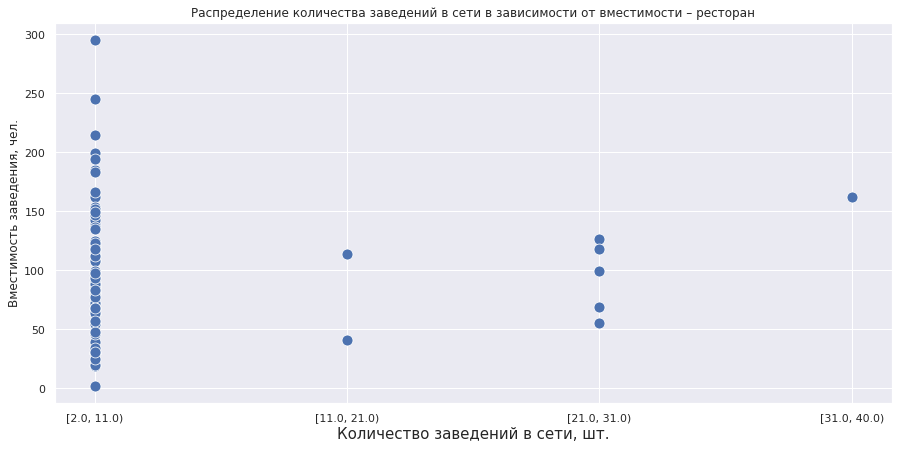

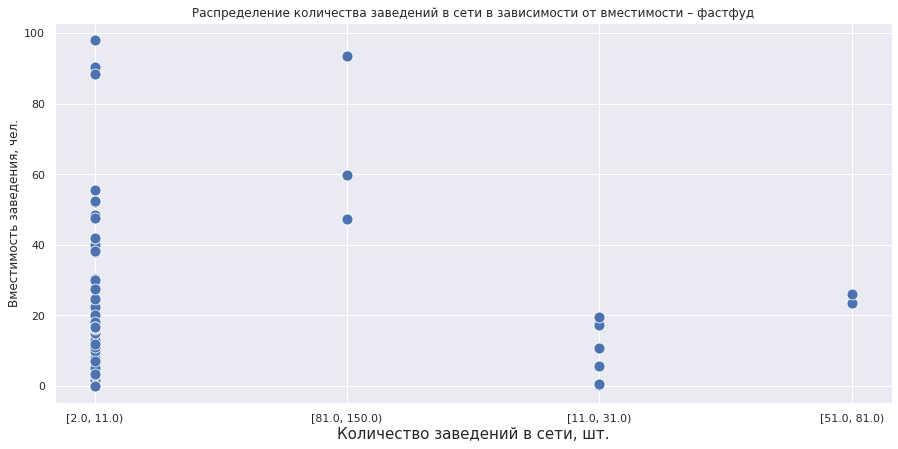

In [105]:
columns = ['кафе', 'ресторан', 'фастфуд']
numbers = ['mean_num_кафе', 'mean_num_ресторан','mean_num_фастфуд']
for i in range(len(columns)):
    ax=sns.scatterplot(data = grouped_chain.loc[grouped_chain[columns[i]] != 'nan'], 
                x = str(columns[i]), 
                y = numbers[i],
                s = 120)
    ax.set_xlabel("Количество заведений в сети, шт.", fontsize=15)
    ax.set_ylabel("Вместимость заведения, чел.")
    ax.set_title(f"Распределение количества заведений в сети в зависимости от вместимости – {columns[i]}")
    plt.show()

Если взять сеть кафе или фастфуда, то при численности заведений в сети от 2 до 10, вероятность попасть на сеть с количеством посадочных мест от 0 до 20 будет гораздо выше (наиболее плотное размещение точек на соответствующих графиках). Сети ресторанов чаще всего включают в себя не более 10 заведений и вместимость здесь чаще всего 50-100 человек.

5. Для каждого вида объекта общественного питания опишем среднее количество посадочных мест. Определим, какой тип объектов предоставляет в среднем самое большое количество посадочных мест

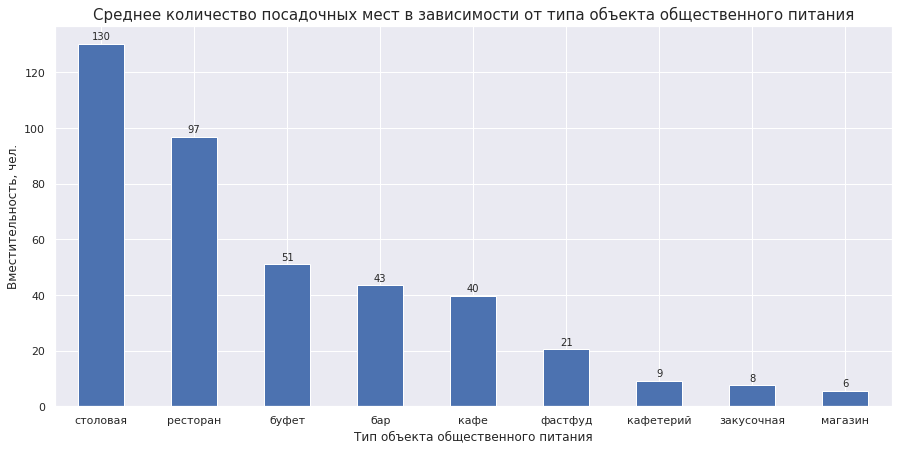

In [111]:
ax=df.groupby('object_type')['number'].mean().sort_values(ascending=False).plot.bar()
ax.set_xlabel('Тип объекта общественного питания', size = 12)
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Вместительность, чел.', size = 12)
plt.title('Cреднее количество посадочных мест в зависимости от типа объекта общественного питания', size = 15)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
    (bar.get_x() + bar.get_width() / 2,
    bar.get_height()), ha='center', va='center',
    size=10, xytext=(0, 7),
    textcoords='offset points')
plt.show()

Ожидаемо столовые являются наиболее вместительными: нужно обеспечить местами наплыв посетителей в пиковые часы - завтрак, обед, ужин. Далее идут рестораны, для которых количество мест наиболее критично, т.к. посетители здесь задерживаются дольше, чем, например, в кафетериях, закусочных или магазинах.

6. Выделим в отдельный столбец информацию об улице из столбца address

In [39]:
df.sample(5)

,id,object_name,chain,object_type,address,number
8432,22442,халяль,нет,кафе,"город Москва, Нижняя Красносельская улица, дом 32/29, строение 2",22
3254,27389,школьная столовая № 1874,нет,столовая,"город Москва, улица Маршала Новикова, дом 13",170
12401,193058,hang kong,нет,кафе,"улица Льва Толстого, дом 18",70
4076,82904,«такси 18»,нет,кафе,"город Москва, 1-й Нагатинский проезд, дом 15",15
9685,168948,-мороженное «gelateria 17»,нет,кафе,"город Москва, Духовской переулок, дом 17",4


In [40]:
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд',
         'село','аллея','бульвар','набережная','тупик','линия']

str_pat = r"(\b[^,]*(?:{})[^,]*)".format("|".join(words))

df["street"] = df["address"].str.extract(str_pat)

In [42]:
df.sample(5)

,id,object_name,chain,object_type,address,number,street
14389,211630,готовые блюда милти,нет,буфет,"город Москва, улица Кулакова, дом 20, строение 1А",1,улица Кулакова
7269,28999,школа 1472 кшп «загорье»,нет,столовая,"город Москва, улица Садовники, дом 12",240,улица Садовники
4572,29246,комбинат питания школа 921,нет,столовая,"город Москва, Рязанский проспект, дом 82, корпус 4",100,Рязанский проспект
14032,208827,mister x,нет,бар,"город Москва, улица Новый Арбат, дом 21",42,улица Новый Арбат
1370,154280,пиво-воды,нет,бар,"город Москва, Щёлковское шоссе, дом 85, корпус 1",22,Щёлковское шоссе


7.Построим график топ-10 улиц по количеству объектов общественного питания.

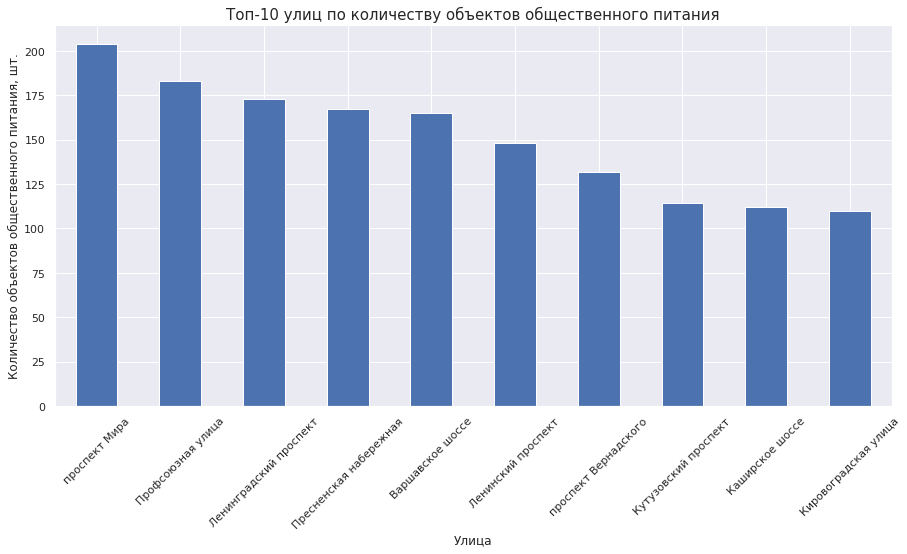

In [113]:
ax = df['street'].value_counts().head(10).plot(kind = 'bar')
ax.set_xlabel('Улица', size = 12)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel('Количество объектов общественного питания, шт.', size = 12)
plt.title('Топ-10 улиц по количеству объектов общественного питания', size = 15)
plt.show()

Улицы с наибольшим скоплением заведений общепита насчитывают от 100 до 200 объектов на улицу. Так, протяженность проспекта Мира около 9 км, ул. Профсоюзной - 9,3 км, Ленинградского проспекта - 5,6 км. Т.е. плотность расположения заведений на Ленинградском проспекте выше, чем на первых двух улицах. И здесь фактор протяженности улицы может не быть основным. В приоритете - количество мест притяжения и проходимость (трафик) улицы. 

Для того, чтобы узнать, в каких районах Москвы находятся эти улицы, обратимся к сайту http://mosopen.ru.  
Так улица "Проспект Мира" проходит сразу по нескольким районам: Алексеевский, Марьина роща, Мещанский, Останкинский, Ростокино, Свиблово и Ярославский на территории Северо-Восточного административного округа и Центрального административного округа города Москвы (http://mosopen.ru/street/15820). Т.е. для определения района расположения объекта общественного питания нужно не только наименование улицы, но и номера дома-строения - данные столбца address.
Воспользуемся сайтом ДубльГис Москва.

Сохраним в новую переменную список улиц из тор-10.

In [44]:
df['street'].value_counts().head(10).index

Index(['проспект Мира', 'Профсоюзная улица', 'Ленинградский проспект',
       'Пресненская набережная', 'Варшавское шоссе', 'Ленинский проспект',
       'проспект Вернадского', 'Кутузовский проспект', 'Каширское шоссе',
       'Кировоградская улица'],
      dtype='object')

In [45]:
streets = ['проспект Мира', 'Профсоюзная улица', 'Ленинградский проспект',
           'Пресненская набережная', 'Варшавское шоссе', 'Ленинский проспект',
           'проспект Вернадского', 'Кутузовский проспект', 'Каширское шоссе',
           'Кировоградская улица']

Выделим из исходных данных те адреса, которые находятся по улицам в переменной streets

In [46]:
top_streets = df.query('street == @streets')
top_streets.head()

,id,object_name,chain,object_type,address,number,street
151,155973,«андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,Варшавское шоссе
152,23618,«subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,Варшавское шоссе
153,155852,«ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,Варшавское шоссе
154,152556,шаурма в пите,нет,фастфуд,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,Варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,Варшавское шоссе


Один и тот же адрес может встречаться в ДубльГис несколько раз, например, в городе Москва и городе Реутов. Напишем функцию для поиска адреса только в Москве, передадим ее в цикл для обработки информации сайта ДубльГис. 

In [47]:
def find_moscow(spisok):
    for a in spisok:
        s = str(a.contents[0])
        if s.find("Москва") >= 0:
            t=re.findall('[А-я]+\w+\D+\w район', a.contents[0])
            if len(t) < 1:
                return 0
            else:
                return t[0]
        
        
         
    return "no Moscow"

#### Парсер 1

In [48]:
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0'
      }
gis =[]

for row in top_streets['address']:
    url = 'https://2gis.ru/moscow/search/'+row
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, 'lxml')
    d = soup.find_all('div', attrs={'class': '_18ijp46'})
    if (len(d) > 0):
        r = find_moscow(d)
    else:
        r = 'no parse'
    gis.append(r)

In [49]:
gis

['Донской район',
 'Донской район',
 'Донской район',
 'Нагорный район',
 'Нагорный район',
 'Чертаново Южное район',
 'Гагаринский район',
 'Ломоносовский район',
 'Ломоносовский район',
 'Ломоносовский район',
 'Ломоносовский район',
 'Ломоносовский район',
 'Проспект Вернадского район',
 'no parse',
 'Тропарёво-Никулино район',
 'Тропарёво-Никулино район',
 'Тропарёво-Никулино район',
 'Тропарёво-Никулино район',
 'Тропарёво-Никулино район',
 'Фили-Давыдково район',
 'Нагатино-Садовники район',
 'Нагатино-Садовники район',
 'Москворечье-Сабурово район',
 'Москворечье-Сабурово район',
 'Москворечье-Сабурово район',
 'Чертаново Центральное район',
 'Чертаново Центральное район',
 'no parse',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Дорогомилово район',
 'Беговой район',
 'Беговой район',
 'Беговой район',
 'Беговой райо

Добавим полученный список в исходную таблицу, посмотрим, по какому количеству адресов удалось получить район расположения.

In [50]:
top_streets['gis']=gis

In [51]:
top_streets.sample(5)

,id,object_name,chain,object_type,address,number,street,gis
9349,167393,даблби,нет,кафе,"город Москва, Пресненская набережная, дом 10",10,Пресненская набережная,Пресненский район
9958,171142,salon,нет,ресторан,"город Москва, Кутузовский проспект, дом 12, строение 2",100,Кутузовский проспект,"ст2, Дорогомилово район"
6996,29183,столовая академии федеральной пограничной службы россии,нет,столовая,"город Москва, Ленинградский проспект, дом 3, строение 1",90,Ленинградский проспект,Сокол район
13125,195461,пекарня,нет,фастфуд,"город Москва, Кировоградская улица, владение 15А",0,Кировоградская улица,0
8852,158324,грузинская кухня хачапурная,нет,фастфуд,"город Москва, Кировоградская улица, дом 13А",50,Кировоградская улица,no parse


In [52]:
top_streets['gis'].value_counts(normalize=True).head()

no parse                 0.468170
Пресненский район        0.063660
Мещанский район          0.034483
Чертаново Южное район    0.027851
Дорогомилово район       0.026525
Name: gis, dtype: float64

Не распарсилась половина адресов. По ним находятся коммерческие объекты, например, гостиницы, ТРЦ и другие. Информация о районе расположения таких объектов находится на странице, отличной от страницы расположения адреса объекта. 

Попытаемся получить информацию о районах через сайт http://ginfo.ru. Для подготовки информации проведем транслитерацию списка переменной street, поместим эти результаты в столбец translit таблицы top_streets

In [53]:
def translit(data):
    if data == 'проспект Мира':
        return 'prospekt_mira'
    if data == 'Профсоюзная улица':
        return 'profsoyuznaya_ulica'
    if data == 'Ленинградский проспект':
        return 'leningradskiy_prospekt'
    if data == 'Пресненская набережная':
        return 'presnenskaya_naberezhnaya'
    if data == 'Варшавское шоссе':
        return 'varshavskoe_shosse'
    if data == 'Ленинский проспект':
        return 'leninskiy_prospekt'
    if data == 'проспект Вернадского':
        return 'prospekt_Vernadskogo'
    if data == 'Кутузовский проспект':
        return 'kutuzovskiy_prospekt'
    if data == 'Каширское шоссе':
        return 'kashirskoe_shosse'
    if data == 'Кировоградская улица':
        return 'kirovogradskaya_ulica'
    return 'иное'
top_streets['translit'] = top_streets['street'].apply(translit)

In [54]:
top_streets.sample(3)

,id,object_name,chain,object_type,address,number,street,gis,translit
14584,221403,предприятие быстрого обслуживания «кофе с собой»,нет,фастфуд,"город Москва, Варшавское шоссе, дом 95, корпус 1",0,Варшавское шоссе,no parse,varshavskoe_shosse
3111,26328,нептун,нет,ресторан,"город Москва, Профсоюзная улица, дом 27, корпус 1",100,Профсоюзная улица,Черёмушки район,profsoyuznaya_ulica
9296,166972,здравствуй рыба,нет,ресторан,"город Москва, Кутузовский проспект, дом 12, строение 2",36,Кутузовский проспект,"ст2, Дорогомилово район",kutuzovskiy_prospekt


In [55]:
def dom(s):
    pattern = r"\sдом (\d+[А-яёЁ]?)"
    match = re.search(pattern, s)
    if match != None:
        d = match[1]
    else:
        d=''
    pattern = r"\sвладение (\d+[А-яёЁ]?)"
    match = re.search(pattern, s)
    if match != None:
        g= 'вл' + match[1]
    else:
        g=''
    pattern = r"\sстроение (\d+[А-яёЁ]?)"
    match = re.search(pattern, s)
    if match != None:
        f = 'стр' + match[1]
    else:
        f=''
    pattern = r"\sкорпус (\d+[А-яёЁ]?)"
    match = re.search(pattern, s)
    if match != None:
        h = 'к' + match[1]
    else:
        h=''
    return d+g+h+f

#### Парсер 2

In [56]:
headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0'
      }
ginfo =[]
for i,row in top_streets.iterrows():
    url = 'http://ginfo.ru/ulicy/'+row['translit']
    num = dom(row['address'])
    response = requests.get(url, headers = headers)
    soup = BeautifulSoup(response.text, 'lxml')
    d = soup.find_all('div', attrs={'class': 'dom_list'})
    d = str(d)
    d = BeautifulSoup(d, 'lxml')
    n = False
    for element in d.find_all('a'):
        if element.contents[0] == num:
            url_1 = 'http://ginfo.ru' + element['href']
            response_1 = requests.get(url_1, headers = headers)
            soup = BeautifulSoup(response_1.text, 'lxml')
            d_1 = soup.find_all('div', attrs={'class': 'opis_ulica'})
            
            d_1 = BeautifulSoup(str(d_1), 'lxml')
            d_1 = d_1.find_all('a')
            if d_1 != None:
                ginfo.append(d_1[0].contents[0])
            else:
                ginfo.append('no parse')
    
            n=True
            break
    if n == False:
        ginfo.append('no building')
        

In [57]:
ginfo

['Донском районе',
 'Донском районе',
 'Донском районе',
 'Нагорном районе',
 'Нагорном районе',
 'районе Чертаново Южное',
 'Гагаринском районе',
 'no building',
 'no building',
 'no building',
 'no building',
 'Ломоносовском районе',
 'районе Проспект Вернадского',
 'районе Тропарёво-Никулино',
 'районе Тропарёво-Никулино',
 'районе Тропарёво-Никулино',
 'районе Тропарёво-Никулино',
 'районе Тропарёво-Никулино',
 'районе Тропарёво-Никулино',
 'районе Фили-Давыдково',
 'районе Нагатино-Садовники',
 'районе Нагатино-Садовники',
 'районе Москворечье-Сабурово',
 'районе Москворечье-Сабурово',
 'районе Москворечье-Сабурово',
 'районе Чертаново Центральное',
 'районе Чертаново Центральное',
 'районе Чертаново Южное',
 'no building',
 'no building',
 'no building',
 'no building',
 'районе Дорогомилово',
 'районе Дорогомилово',
 'районе Дорогомилово',
 'районе Дорогомилово',
 'районе Дорогомилово',
 'районе Дорогомилово',
 'Беговом районе',
 'Беговом районе',
 'Беговом районе',
 'Беговом ра

Сохраним список в столбец ginfo таблицы top_streets. Посмотрим количество пропусков.

In [60]:
top_streets['ginfo']=ginfo

In [61]:
top_streets['ginfo'].value_counts().head()

no building                     163
Пресненском районе              154
районе Тропарёво-Никулино       87 
районе Чертаново Центральное    83 
Мещанском районе                62 
Name: ginfo, dtype: int64

Количество пропусков всего около 10% - гораздо меньше, чем в попытке с ДубльГис. Объединим данные столбцов gis и ginfo в столбце district.

In [62]:
top_streets = top_streets.replace('no building', np.nan)

In [63]:
top_streets.sample(3)

,id,object_name,chain,object_type,address,number,street,gis,translit,ginfo
12290,204776,кальян бар,нет,бар,"город Москва, Варшавское шоссе, дом 2",24,Варшавское шоссе,Донской район,varshavskoe_shosse,Донском районе
6074,143510,«cezve coffee»,нет,кафе,"город Москва, Профсоюзная улица, дом 126, корпус 3",20,Профсоюзная улица,no parse,profsoyuznaya_ulica,районе Тёплый Стан
7718,106130,yes pizza,нет,фастфуд,"город Москва, Кировоградская улица, дом 13А",25,Кировоградская улица,no parse,kirovogradskaya_ulica,районе Чертаново Центральное


In [64]:
top_streets['district'] = top_streets['ginfo'].combine_first(top_streets['gis'])

In [65]:
top_streets['district'].value_counts()

Пресненском районе                  154
районе Тропарёво-Никулино           87 
районе Чертаново Центральное        83 
Мещанском районе                    62 
районе Аэропорт                     62 
районе Свиблово                     62 
Обручевском районе                  59 
no parse                            53 
Алексеевском районе                 51 
районе Нагатино-Садовники           50 
Донском районе                      49 
Беговом районе                      49 
районе Чертаново Северное           44 
районе Чертаново Южное              43 
районе Тёплый Стан                  43 
Нагорном районе                     42 
районе Дорогомилово                 41 
районе Москворечье-Сабурово         41 
районе Черёмушки                    37 
районе Коньково                     34 
районе Раменки                      31 
Хорошёвском районе                  29 
районе Сокол                        23 
районе Якиманка                     22 
Гагаринском районе                  22 


Удалим строки со значениями no parse и 0. Решим проблему с падежами.

In [66]:
top_streets[top_streets['district'] == 0]

,id,object_name,chain,object_type,address,number,street,gis,translit,ginfo,district
7479,21640,,нет,кафе,"город Москва, Варшавское шоссе, владение 129Г",12,Варшавское шоссе,0,varshavskoe_shosse,NaN,0
7508,21648,петрол комплекс эквипмент кампани,нет,фастфуд,"город Москва, Каширское шоссе, владение 36А",20,Каширское шоссе,0,kashirskoe_shosse,NaN,0
8843,19760,буфет при а-с юго-запад,нет,буфет,"Ленинский проспект, владение 164",16,Ленинский проспект,0,leninskiy_prospekt,NaN,0
8897,74930,предприятие быстрого обслуживания «магбургер»,да,фастфуд,"Варшавское шоссе, владение 99А",20,Варшавское шоссе,0,varshavskoe_shosse,NaN,0
9164,160162,,нет,фастфуд,"город Москва, Каширское шоссе, владение 25Б",10,Каширское шоссе,0,kashirskoe_shosse,NaN,0
9165,160163,,нет,фастфуд,"город Москва, Каширское шоссе, владение 25Б",10,Каширское шоссе,0,kashirskoe_shosse,NaN,0
9166,160631,бистро,нет,фастфуд,"город Москва, Каширское шоссе, владение 25Б, строение 10",0,Каширское шоссе,0,kashirskoe_shosse,NaN,0
9572,165950,старбакс,да,кафе,"город Москва, Ленинградский проспект, владение 37А, корпус 4",10,Ленинградский проспект,0,leningradskiy_prospekt,NaN,0
11496,180143,грузинская выпечка,нет,фастфуд,"город Москва, Каширское шоссе, владение 25Б",4,Каширское шоссе,0,kashirskoe_shosse,NaN,0
11497,180153,кофейня крендель «кофе с собой»,нет,фастфуд,"город Москва, Каширское шоссе, владение 25Б",5,Каширское шоссе,0,kashirskoe_shosse,NaN,0


In [67]:
top_streets = top_streets.drop(top_streets[top_streets.district == 0].index)

In [68]:
top_streets = top_streets.drop(top_streets[top_streets.district == 'no parse'].index)

In [69]:
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

def lemmas_add(data):
    lemmas = m.lemmatize(data)
    del lemmas[-1]
    return ' '.join(lemmas) 
top_streets['lemmas'] = top_streets['district'].apply(lemmas_add)

In [70]:
top_streets.sample(3)

,id,object_name,chain,object_type,address,number,street,gis,translit,ginfo,district,lemmas
7108,28376,столовая рабочая,нет,столовая,"город Москва, Ленинградский проспект, дом 31А, строение 1",40,Ленинградский проспект,no parse,leningradskiy_prospekt,Беговом районе,Беговом районе,беговой район
12331,198296,мармилатта,нет,кафе,"город Москва, Ленинский проспект, дом 75/9",47,Ленинский проспект,Гагаринский район,leninskiy_prospekt,NaN,Гагаринский район,гагаринский район
1477,129980,сушишоп,да,кафе,"город Москва, проспект Мира, дом 146",18,проспект Мира,Алексеевский район,prospekt_mira,Алексеевском районе,Алексеевском районе,алексеевский район


In [71]:
top_streets['lemmas'] = top_streets['lemmas'].str.replace('район', '')

In [72]:
top_streets['lemmas'] = top_streets['lemmas'].str.strip()

In [73]:
top_streets.sample(3)

,id,object_name,chain,object_type,address,number,street,gis,translit,ginfo,district,lemmas
4291,27016,банкетный зал «вечерний-космос»,нет,ресторан,"город Москва, проспект Мира, дом 150",250,проспект Мира,no parse,prospekt_mira,Алексеевском районе,Алексеевском районе,алексеевский
6112,27140,технологии ного бизнеса,нет,ресторан,"город Москва, Профсоюзная улица, дом 61А",70,Профсоюзная улица,no parse,profsoyuznaya_ulica,районе Черёмушки,районе Черёмушки,черемушки
11769,186910,«osteria mario»,нет,ресторан,"город Москва, Пресненская набережная, дом 2",60,Пресненская набережная,Пресненский район,presnenskaya_naberezhnaya,Пресненском районе,Пресненском районе,пресненский


In [74]:
top_streets['lemmas'].value_counts().head(10)

пресненский                167
тропарево - никулино       87 
чертаново   центральный    83 
мещанский                  63 
обручевский                63 
аэропорт                   62 
свиблово                   62 
дорогомилово               61 
беговой                    52 
алексеевский               51 
Name: lemmas, dtype: int64

Выясним, наконец, в каких районах Москвы находятся топ-10 улиц по количеству объектов общественного питания

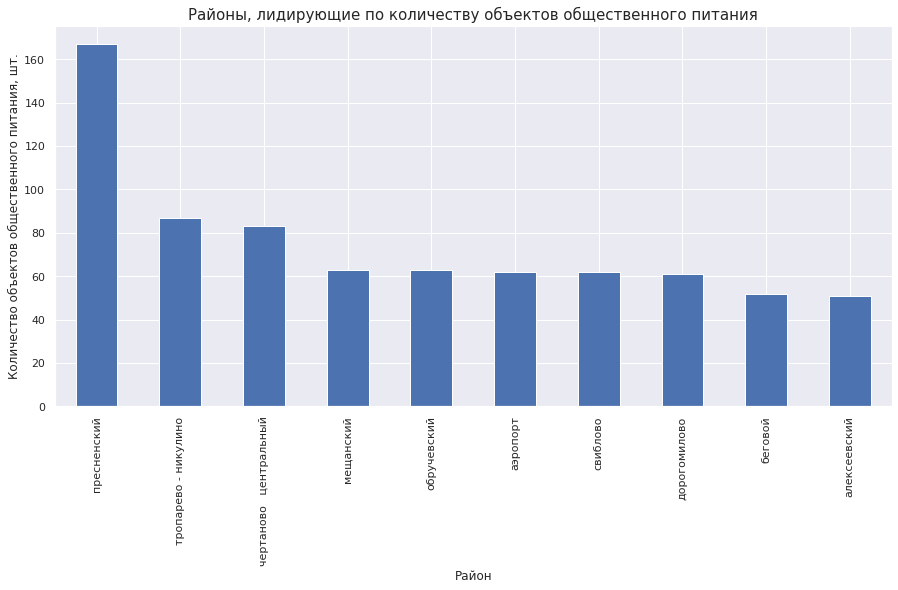

In [119]:
ax = top_streets['lemmas'].value_counts().head(10).plot(kind = 'bar')
ax.set_xlabel('Район', size = 12)
ax.set_ylabel('Количество объектов общественного питания, шт.', size = 12)
plt.title('Районы, лидирующие по количеству объектов общественного питания', size = 15)
plt.show()

Лидирует Пресненский район с количеством объектов около 160 штук. Вероятная причина: бОльшая, по сравнению с другими районами, плотность ТРЦ, БЦ, административный зданий, деловых центров. 

8. Найдем число улиц с одним объектом общественного питания. Выясним, в каких районах Москвы находятся эти улицы

In [76]:
one = df.groupby(['street'])['id'].count().reset_index()
print('Число улиц с одним объектом общественного питания: ', one[one['id'] == 1].count()[0])
print('Доля улиц с одним объектом общественного питания: {:.0%}'. format(one[one['id'] == 1].count()[0]/len(df)))

Число улиц с одним объектом общественного питания:  548
Доля улиц с одним объектом общественного питания: 4%


In [77]:
one_object = one[one['id'] == 1]
one_object.head()

,street,id
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1


Воспользуемся справочником Мосгаза: https://docs.google.com/spreadsheets/d/1CPDYDGjKCb6jGoQt9KR5WOvTspK-dHS3NUrVeqsyqJs/edit#gid=2139935940. Объединим таблицу внешнего источника с таблицей one_object.

In [78]:
from io import BytesIO
spreadsheet_id = '1cxXXOFeVayhzas5oaInPh2rSp52Z0ZQT2s7HfjZyu1Y'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
dist = pd.read_csv(BytesIO(r.content))
dist.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [79]:
joined = one_object.merge(dist, left_on = 'street', right_on = 'streetname')

In [80]:
joined.head()

,street,id,streetname,areaid,okrug,area
0,1-й Балтийский переулок,1,1-й Балтийский переулок,54,САО,Район Аэропорт
1,1-й Басманный переулок,1,1-й Басманный переулок,13,ЦАО,Басманный район
2,1-й Басманный переулок,1,1-й Басманный переулок,15,ЦАО,Красносельский район
3,1-й Ботанический проезд,1,1-й Ботанический проезд,82,СВАО,Район Свиблово
4,1-й Вешняковский проезд,1,1-й Вешняковский проезд,120,ЮВАО,Рязанский район


In [81]:
joined['area'].value_counts(normalize=True).head(10)

Таганский район        0.048214
Район Хамовники        0.046429
Басманный район        0.044643
Тверской район         0.035714
Пресненский район      0.035714
Район Марьина роща     0.032143
Район Арбат            0.032143
Мещанский район        0.026786
Район Замоскворечье    0.025000
Район Лефортово        0.021429
Name: area, dtype: float64

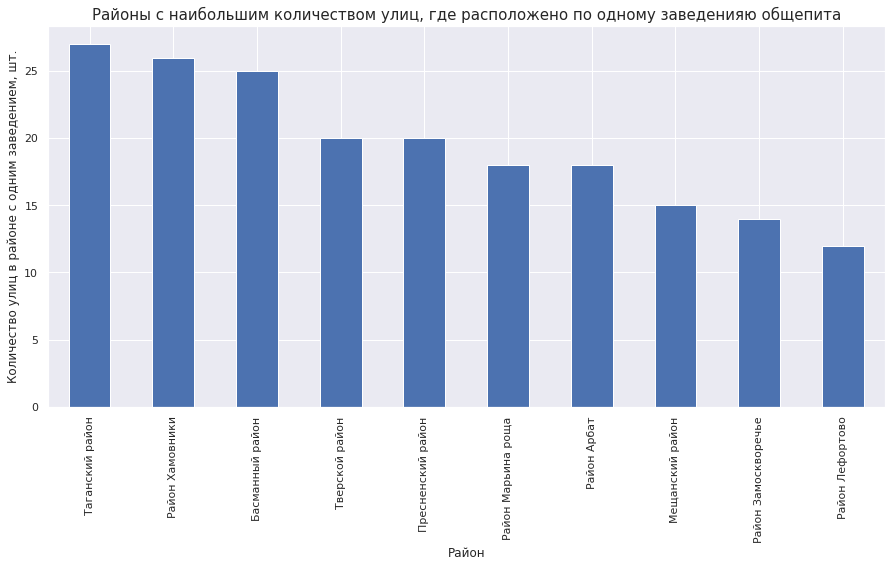

In [120]:
ax = joined['area'].value_counts().head(10).plot(kind = 'bar')
ax.set_xlabel('Район', size = 12)
ax.set_ylabel('Количество улиц в районе с одним заведением, шт.', size = 12)
plt.title('Районы с наибольшим количеством улиц, где расположено по одному заведенияю общепита', size = 15)
plt.show()

Чуть больше 25 улиц в Таганском, Басманном районах и районе Хамовники размещают по одному заведению общепита. В целом есть пересечения по районам из топ-10 с районами, где много улиц с одним объектом общепита. Т.е. сделать вывод о перспективности какого-либо района сложно. Все зависит от трафика (проходимости) конркретной улицы и объектов, на ней расположенных.

9. Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания. Для анализа возьмем топ-10 улиц из п.7

In [83]:
top_streets.sample(3)

,id,object_name,chain,object_type,address,number,street,gis,translit,ginfo,district,lemmas
3429,23570,столовая школа 875 (807),нет,столовая,"город Москва, проспект Вернадского, дом 101, корпус 6",150,проспект Вернадского,no parse,prospekt_Vernadskogo,районе Тропарёво-Никулино,районе Тропарёво-Никулино,тропарево - никулино
6474,19959,сбарро,да,фастфуд,"город Москва, проспект Вернадского, дом 6",36,проспект Вернадского,no parse,prospekt_Vernadskogo,районе Раменки,районе Раменки,раменки
3497,114263,казан-чайхона,нет,кафе,"город Москва, Ленинградский проспект, дом 23",40,Ленинградский проспект,Беговой район,leningradskiy_prospekt,Беговом районе,Беговом районе,беговой


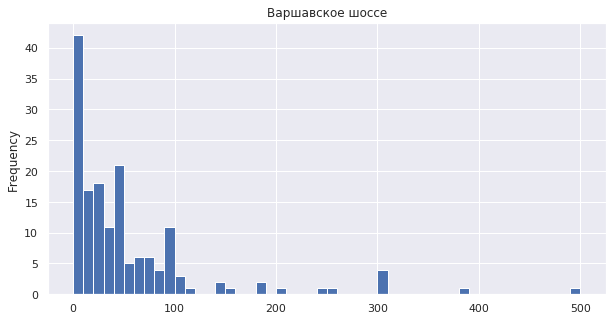

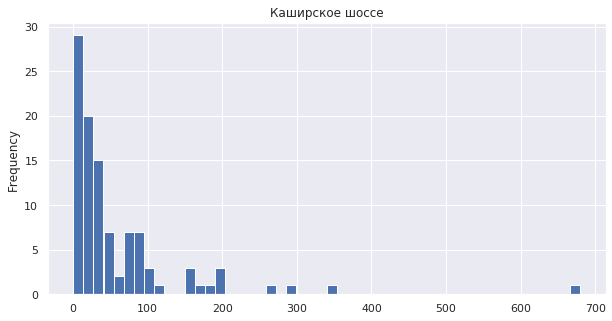

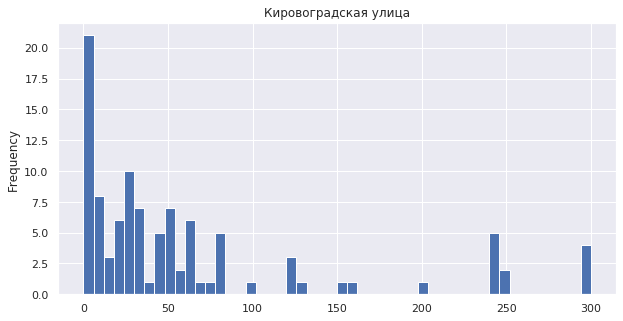

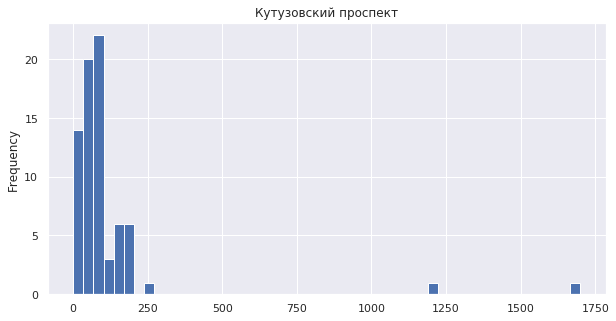

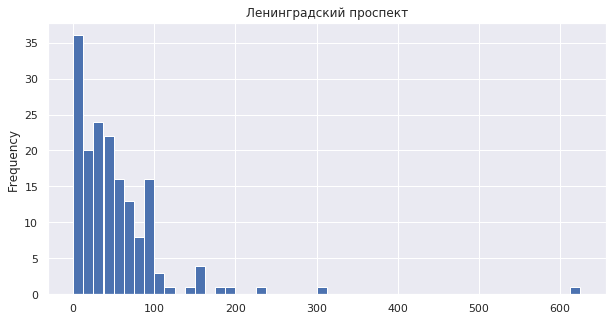

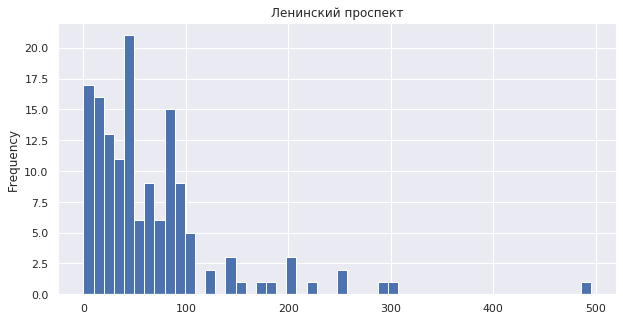

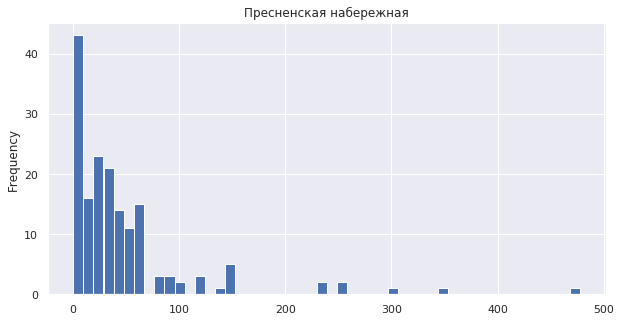

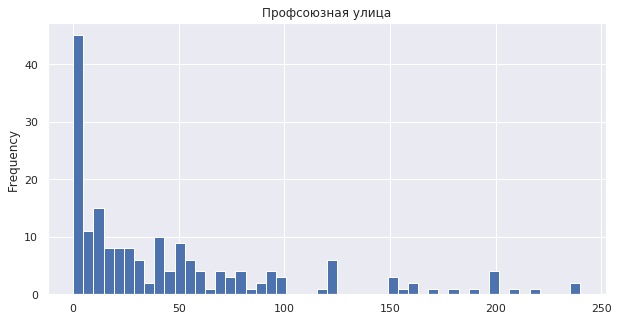

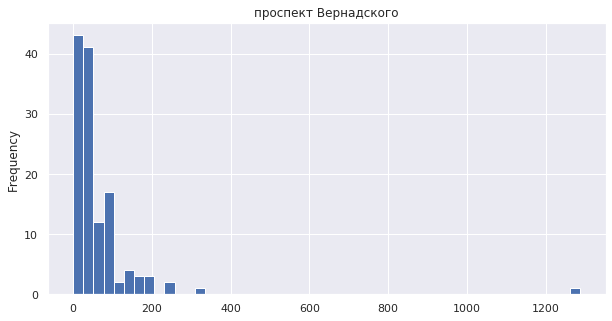

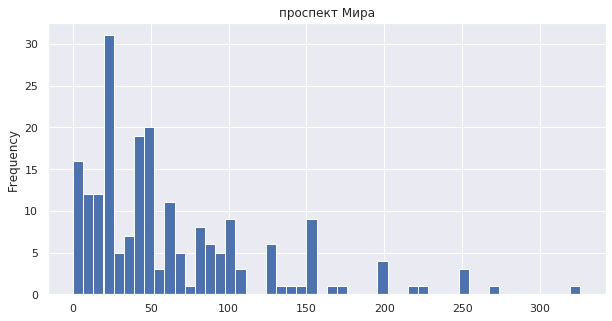

In [84]:
for streets, group_data in top_streets.groupby('street'):
    group_data.plot(kind = 'hist', y = 'number', bins = 50, title = streets, figsize = (10,5), legend = False)

Основной вывод, который можно сделать из представленных графиков - количество посадочных мест варьируется от 0 до 100. При чем, в большинстве районов - это ноль посадочных мест. Исключения - Ленинский проспект и проспект Мира, здесь преобладают заведения с вместительностью 20-30 человек.

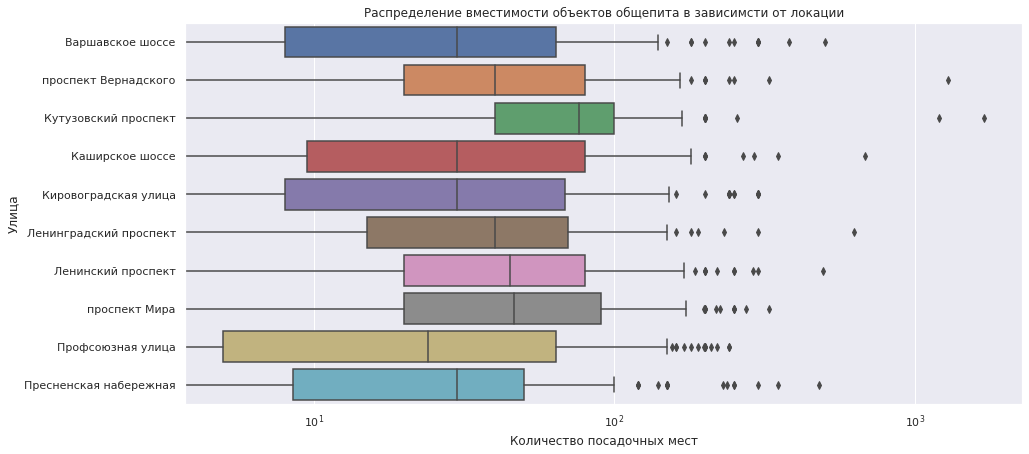

In [85]:
ax=sns.boxplot(x="number", y="street", data=top_streets)
plt.xscale('log')
ax.set_title("Распределение вместимости объектов общепита в зависимости от локации")
ax.set_xlabel("Количество посадочных мест")
ax.set_ylabel("Улица")
plt.show()

Значение количества посадочных мест смещено вправо и тяготеет к 100 (10^2). Медианные значения вместимости по всем улицам смещено также вправо от значения 32 (что примерно равняется 10 в степени 1,5, середина отрезка между 10^1 и 10^2). Т.е. в среднем на всех улицах топ-10 заведения вмещают в себя от 32 до 56 человек (10^1.5 - 10^1.75). На проспектах Вернадского, Кутузовском, Ленинградском, Ленинском и Мира 50% заведений вмещает от 17 до 100 человек (от 10^1.25 до 10^2).

Проверим есть ли различия в количестве посадочных мест в заведениях из топ-10 улиц и улиц с одним объектом. Добавим в таблицу one_object столбец с количеством посадочных мест из таблицы df. 

In [86]:
one_object = joined.merge(df[['street', 'number']], on = 'street', how='left')

In [87]:
one_object.head()

,street,id,streetname,areaid,okrug,area,number
0,1-й Балтийский переулок,1,1-й Балтийский переулок,54,САО,Район Аэропорт,60
1,1-й Басманный переулок,1,1-й Басманный переулок,13,ЦАО,Басманный район,50
2,1-й Басманный переулок,1,1-й Басманный переулок,15,ЦАО,Красносельский район,50
3,1-й Ботанический проезд,1,1-й Ботанический проезд,82,СВАО,Район Свиблово,40
4,1-й Вешняковский проезд,1,1-й Вешняковский проезд,120,ЮВАО,Рязанский район,20


In [88]:
print('Медианное значение вместимости в заведениях на улицах с одним объектом: {:.0f}'.format(one_object['number'].median()))
print('Медианное значение вместимости в заведениях из топ-10 улиц: {:.0f}'.format(top_streets['number'].median()))

Медианное значение вместимости в заведениях на улицах с одним объектом: 56
Медианное значение вместимости в заведениях из топ-10 улиц: 40


Различия в медианных значениях существенные. Проведем стат анализ.

Нулевая гипотеза: в среднем количество посадочных мест в заведениях из топ-10 улиц и улиц с одним объектом равны. Альтернативная гипотеза: количество посадочных мест в заведениях из топ-10 улиц и улиц с одним объектом разные.  
Поскольку данные о вместимости объектов не распределены нормально, для проверки гипотезы используем критерий Манна-Уитни.

In [89]:
alpha = 0.05
results = st.mannwhitneyu(top_streets['number'], one_object['number'], alternative = 'two-sided')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 5.27982891371757e-19
Отвергаем нулевую гипотезу


Вместимость заведений с улиц с одним объектом не равна вместимости заведений с топ-10 улиц. Возможно, действительно больше. Это может объясняться хорошей заполняемостью в отсутствии конкуренции.

#### 2.1 Вывод

1. 40% рынка занимают кафе, далее в первой пятерке: столовые, закусочные, фастфуд и рестораны.
2. 81% заведений - несетевые объекты.
3. Сетевое распределение характерно для фастфуда, 40% предприятий быстрого питания принадлежит сетям.
4. 90% заведений вмещают не более 120 человек, только 1% вмещает более 275 человек. Сетевые объекты общественного питания в основном предпочитают иметь большое количество точек обслуживания с меньшим количеством посадочных мест. 
В кафе две трети объектов вмещают до 60 человек. В сетевом фастфуде порядка 400 объектов вмещают одновременно до 30 человек. Это объяснется необходимостью обеспечить масштаб производства: чтобы поддерживать низкий уровень цен, нужно обслужить как можно больше человек с наименьшими расходами (небольшая площадь помещения, неудобные твердые стулья - условия для быстрой смены посетителей). 
В категории "ресторан" примерно равное распределение в группах 30-60, 60-90 и 90-120 человек - около 100 ресторанов в каждой группе. Здесь, в отличие от фастфуда, наоборот плотность размещения посетителей меньше,  мебель комфортная, средний чек ощутимее выше. Здесь, конечно, определяющий фактор - уровень кухни.
5. Если взять сети кафе, фастфуда или ресторанов, то чаще всего встечаются сети, включающие в себя не более 10 заведений. При этом в кафе и фастфуде чаще всего вместимость будет составлять 0-20 человек, в ресторане - 50-100 чеовек.
6. Самые вместительные категории - столовые и рестораны.
7. По количетству объектов общественного питания лидирует Пресненский район (около 160 штук). Вероятная причина: бОльшая, по сравнению с другими районами, плотность ТРЦ, БЦ, административный зданий, деловых центров.
8. Чуть больше 25 улиц в Таганском, Басманном районах и районе Хамовники размещают по одному заведению общепита. В целом есть пересечения по районам из топ-10 с районами, где много улиц с одним объектом общепита. Т.е. сделать вывод о перспективности какого-либо района сложно. Все зависит от трафика (проходимости) конркретной улицы и объектов, на ней расположенных.
9. Если посмотреть на распределение вместимости для улиц с большим количеством объектов общественного питания, то количество посадочных мест варьируется от 0 до 100. При чем, в большинстве районов - это ноль посадочных мест. Исключения - Ленинский проспект и проспект Мира, здесь преобладают заведения с вместительностью 20-30 человек.
9. Вместимость заведений с улиц с одним объектом не равна вместимости заведений с топ-10 улиц. Возможно, больше. Это может объясняться хорошей заполняемостью в отсутствии конкуренции.

### 3 Общие рекомендации

Оптимальный формат - кафе: 
- для фастфуда - роботы - слишком дорогое удовольствие;
- для ресторана - посетителям часто важно общение с официантом по составу блюд и напиткам.
Соглавсно анализу - самый распространенный вариант - кафе рядом или в торговом/бизнес центре, отеле. Но особенность нового кафе - роботы. Вряд ли сотруднки бизнес-центров, пришедшие на обед, будут впечатлены формой обслуживания - здесь нужно быстро и с понятным меню и обслуживанием. В ТРЦ это часто открытый фуд-корт, с хаотично расставленными столами-стульями. Роботам не проехать. В отеле концепция роботов вообще не приживется. Нужно отдельное помещение.  
Ассоциация с роботами - наука, прогресс, кибернетика, научная фантастика. Ожидать особого интереса от взрослых дядей-тетей к такому проекту не стоит. Следовательно, размещение должно быть около вузов и студенческих городков, мест отдыха молодежи. Студенты - народ бедный, средний чек не задрать, поэтому для окупаемости вместимость должна быть существенной. Вероятно, 50-80 человек.  
Делать какое-либо прогнозы по району расположения сложно. Мало данных для исследования мест скопления молодежи, если мы останавливаемся на этой целевой аудитории. Нужно узнать размещение и численность основных вузов города, мест притяжения молодежи, анализировать отдельно форматы общепита в этих районах. Возможно, будет иметь смысл рассматривать улицы, где число объектов общественного питания невелико, т.к. анализ показывает, что вместимость 50-80 человек как раз характерно при отсутствии сильной кокуренции.